## Import dependecies

In [63]:
import gc
import math
import sys
import time
import warnings
import logging
import random
import json
from scipy import stats
from os.path import join, basename, splitext, isfile
from os import listdir
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import cooler
import cooltools

import hichew
from hichew.calling import boundaries, domains, clusters
from hichew.compute import normalize, d_scores, insulation_scores, silhouette
from hichew.loader import cool_files
from hichew.plot import clusters_dynamics, viz_opt_curves, viz_tads, _pca, _tsne


In [31]:
import logging
import time
import operator
import os
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift

from hichew.lib import utils

In [32]:
sns.set(context='paper', style='whitegrid')
warnings.filterwarnings("ignore")

In [33]:
%matplotlib inline

In [34]:
def to_asterix(p):
    if p > 0.05:
        p_results = 'ns'
    elif p > 0.01:
        p_results = '*'
    elif p > 0.001:
        p_results = '**'
    elif p > 0.0001:
        p_results = '***'
    else:
        p_results = '****'
    return p_results

In [56]:
def _clusters_dynamics_(df, columns, clusters):
    """
    Function to vizualize dynamics of clusters in space of stages.
    :param df: dataframe with performed clustering.
    :param columns: list of names of columns by which clustering was performed
    :param clusters: name of df column with clusters
    :return: seaborn colors palette to encode clusters with certain colors.
    """
    n_clusters = len(set(df[clusters]))
    method = clusters.split('_')[1]
    colors = sns.color_palette('rainbow', n_clusters)
    colors1 = [[max(x[0] - 0.2, 0), max(x[1] - 0.2, 0), max(x[2] - 0.2, 0)] for x in colors]
    fig, axes = plt.subplots(n_clusters, 1, sharey=True, figsize=[4*5, int(4*15 * n_clusters / 4)])

    data_min = math.floor(df[columns].values.min())
    data_max = math.ceil(df[columns].values.max())
    data_range = data_max - data_min
    data_max_new = data_max + data_range * 0.2
    data_max_new = math.ceil(data_max_new)
    
    # get significance
    p_vals_wilcox = {}
    p_vals_ks = {}
    for i in range(n_clusters):
        sub_df = df[df[clusters] == i]
        pvs_w = []
        pvs_ks = []
        for j in range(len(columns) - 1):
            pvs_w.append(to_asterix(stats.wilcoxon(sub_df[columns[j]], sub_df[columns[j + 1]]).pvalue))
            pvs_ks.append(to_asterix(stats.ks_2samp(sub_df[columns[j]], sub_df[columns[j + 1]]).pvalue))
        p_vals_wilcox[i] = pvs_w
        p_vals_ks[i] = pvs_ks
    
    v_pres = {}
    for v, (i, r) in zip(df[clusters], df.iterrows()):
        color = colors[v]
        if not v in v_pres.keys():
            v_pres[v] = 0
            try:
                axes[v].plot(r[columns], label=v, color=color, alpha=0.4)
            except:
                axes.plot(r[columns], label=v, color=color, alpha=0.4)
        else:
            try:
                axes[v].plot(r[columns].values, color=color, alpha=0.4)
            except:
                axes.plot(r[columns].values, color=color, alpha=0.4)
        v_pres[v] += 1

    centroids = [list(np.mean(df[df[clusters] == nk][columns])) for nk in range(n_clusters)]
    for v, c in enumerate(centroids):
        color = colors1[v]
        try:
            axes[v].plot(c, color=color, alpha=0.9, lw=3)
            # significance
            for j in range(len(columns) - 1):
                h = (data_max_new - data_max) * 0.3
                if j % 2 == 0:
                    y = data_max
                else:
                    y = data_max + h * 1.5
                x1, x2 = j, j + 1
                axes[v].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c='black')
                axes[v].text((x1+x2)*.5, y+1.1*h, "{}".format(p_vals_wilcox[v][j]), ha='center', va='bottom', color='black', fontsize=30, fontfamily='courier')
        except:
            # significance
            for j in range(len(columns) - 1):
                h = (data_max_new - data_max) * 0.3
                if j % 2 == 0:
                    y = data_max
                else:
                    y = data_max + h * 1.5
                x1, x2 = j, j + 1
                axes[v].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c='black')
                axes[v].text((x1+x2)*.5, y+1.1*h, "{}".format(p_vals_wilcox[v][j]), ha='center', va='bottom', color='black', fontsize=30, fontfamily='courier')
            axes.plot(c, color=color, alpha=0.9, lw=3)

    for v in v_pres:
        try:
            axes[v].set_xticklabels([])
            axes[v].set_ylim(data_min, data_max_new)
            axes[v].set_title("Cluster: {} N: {}".format(v, v_pres[v]), fontsize=60)
            axes[v].tick_params(axis='y', which='major', labelsize=50)
            axes[v].tick_params(axis='y', which='minor', labelsize=50)
            axes[v].grid(True)
        except:
            axes.set_xticklabels([])
            axes.set_ylim(data_min, data_max_new)
            axes.set_title("Cluster: {} N: {}".format(v, v_pres[v]), fontsize=60)
            axes.tick_params(axis='y', which='major', labelsize=50)
            axes.tick_params(axis='y', which='minor', labelsize=50)
            axes.grid(True)

    try:
        axes[-1].set_xticklabels(columns, rotation=90, fontsize=60)
    except:
        axes.set_xticklabels(columns, rotation=90, fontsize=60)

    plt.draw()
    plt.show()

    return colors

In [57]:

def _clusters_(df, colnames, method='kmeans', n_clusters=6, rs=42, damping=0.7, max_iter=400, convergence_iter=15):
    """
    Function to perform clustering under the given (optimal) segmentation.
    :param df: dataframe with segmentation and calculated (and normalized) D-scores / insulation scores for each stage of development.
    :param colnames: list of names of columns by which to perform clustering
    :param method: clustering method. Available: 'kmeans', 'meanshift', 'hierarchical', 'spectral', 'affinity_propagation'.
    :param n_clusters: number of clusters
    :param rs: random state for clustering/tSNE methods. Pass 0 in case you want to have no random state during your experiments.
    :param damping: damping parameter for affinity propagation clustering.
    :param max_iter: max_inter parameter for affinity propagation clustering.
    :param convergence_iter: convergence_iter parameter for affinity propagation clustering.
    :return: adjusted dataframe with clustering (with a column 'cluster_METHOD' added, where METHOD is a clustering method.
    """
    if method == 'kmeans':
        km = KMeans(n_clusters=n_clusters, random_state=rs, ).fit(df[colnames])
        centroids, labels_ = km.cluster_centers_, km.labels_
        df.loc[:, "cluster_kmeans"] = labels_
    elif method == 'meanshift':
        ms = MeanShift().fit(df[colnames])
        centroids, labels_ = ms.cluster_centers_, ms.labels_
        df.loc[:, "cluster_meanshift"] = labels_
    elif method == 'hierarchical':
        ac = AgglomerativeClustering(n_clusters=n_clusters).fit(df[colnames])
        labels_ = ac.labels_
        df.loc[:, "cluster_hierarchical"] = labels_
    elif method == 'spectral':
        sc = SpectralClustering(n_clusters=n_clusters, n_components=n_clusters, random_state=rs, gamma=1., affinity='rbf', n_neighbors=10, assign_labels='kmeans').fit(df[colnames])
        labels_ = sc.labels_
        df.loc[:, "cluster_spectral"] = labels_
    elif method == 'affinity_propagation':
        ap = AffinityPropagation(damping=damping, max_iter=max_iter, convergence_iter=convergence_iter, random_state=rs).fit(df[colnames])
        centroids, labels_ = ap.cluster_centers_, ap.labels_
        df.loc[:, "cluster_affinity_propagation"] = labels_
    else:
        logging.error('CALL|CLUSTERS| Choose correct clustering method!')
        raise Exception('Choose correct clustering method!')

    return df

In [36]:
def run_elbow(model, data, stages, k, metric='distortion'):
    visualizer = KElbowVisualizer(model, k=(2,k), metric=metric, timings=False)
    visualizer.fit(data[stages])
    visualizer.show()

In [37]:
def run_silhouette(model, data, stages, k):
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(data[stages])
    visualizer.show()

In [38]:
def _tsne_(df, columns, clusters, palette, perplexity=30, rs=42):
    """
    Function to perform tSNE for the clustering.
    :param df: dataframe with performed clustering.
    :param columns: list of names of columns by which clustering was performed
    :param clusters: name of df column with clusters
    :param perplexity: parameter for tSNE method.
    :param rs: random state for tSNE method.
    :return: --
    """
    n_clusters = len(set(df[clusters]))
    method = clusters.split('_')[1]

    #time_start = time.time()
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=rs)
    tsne_results = tsne.fit_transform(df[columns])
    #logging.info("PLOT|TSNE| t-SNE done! Time elapsed: {} seconds".format(time.time() - time_start))
    df_tsne = df.copy()
    df_tsne['tsne-2d-one'] = tsne_results[:, 0]
    df_tsne['tsne-2d-two'] = tsne_results[:, 1]
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue=clusters,
        palette=palette,
        data=df_tsne,
        legend="full",
        alpha=0.3
    )
    plt.draw()
    plt.show()

In [39]:
def _pca_(df, columns, clusters, palette, is_pca=True):
    """
    Function to perform PCA (2D and 3D, if applicable) for the clustering.
    :param df: dataframe with performed clustering.
    :param columns: list of names of columns by which clustering was performed
    :param clusters: name of df column with clusters
    :return: --
    """
    n_clusters = len(set(df[clusters]))

    if is_pca:
    
        if len(columns) >= 3:
            pca = PCA(n_components=3)
        else:
            pca = PCA(n_components=2)

        pca_result = pca.fit_transform(df[columns].values)
        df_pca = df.copy()
        df_pca['pca-one'] = pca_result[:, 0]
        df_pca['pca-two'] = pca_result[:, 1]

        if len(columns) >= 3:
            df_pca['pca-three'] = pca_result[:, 2]

        logging.info("PLOT|PCA| Explained variation per principal component: {}".format(pca.explained_variance_ratio_))

        ax = plt.figure(figsize=(16, 10))
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue=clusters,
            palette=palette,
            data=df_pca,
            legend="full",
            alpha=0.3
        )
        plt.draw()
        plt.show()

        if len(columns) >= 3:
            ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
            ax.scatter(
                xs=df_pca["pca-one"],
                ys=df_pca["pca-two"],
                zs=df_pca["pca-three"],
                c=df_pca[clusters],
                cmap='tab10'
            )
            ax.set_xlabel('pca-one')
            ax.set_ylabel('pca-two')
            ax.set_zlabel('pca-three')

            plt.draw()
            plt.show()
    
    else:
        if len(columns) == 2:
            ax = plt.figure(figsize=(10, 10))
            sns.scatterplot(
                x=columns[0], y=columns[1],
                hue=clusters,
                palette=palette,
                data=df,
                legend="full",
                alpha=0.3
            )
            #ax.suptitle("Method: {}, n_clusters: {}".format(cluster_col.split('_')[1], n_clusters))
            plt.draw()
            plt.show()
        elif len(columns) == 3:
            ax = plt.figure(figsize=(16, 16)).gca(projection='3d')
            ax.scatter(
                xs=df[columns[0]],
                ys=df[columns[1]],
                zs=df[columns[2]],
                c=df[clusters],
                cmap='tab10'
            )
            ax.set_xlabel(columns[0])
            ax.set_ylabel(columns[1])
            ax.set_zlabel(columns[2])
            #ax.set_title("Method: {}, n_clusters: {}, Explained variation: {}".format(len(stages), method, n_clusters, pca.explained_variance_ratio_))

            plt.draw()
            plt.show()


## Specify parameters

In [54]:
resolution = 10000
clustering_method = 'kmeans'
n_clusters = 4

fountains_path = '../arcuda/clustering/insulation/fountains/{}.csv'
boundaries_path = '../arcuda/clustering/insulation/boundaries/{}.csv'
coolers_path = '../arcuda/coolers/This2022/{}.mcool'

stages_fountains = ['Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                    'WT.danrer11-reduced.mapq_30.1000', 
                    'TR.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_25.danrer11-reduced.mapq_30.1000']

stages_boundaries = ['sperm.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                     'WT.danrer11-reduced.mapq_30.1000', 
                     'TR.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_25.danrer11-reduced.mapq_30.1000']

stages_all = ['sperm.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
              'WT.danrer11-reduced.mapq_30.1000', 
              'TR.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_25.danrer11-reduced.mapq_30.1000']


## Get data

#### Chromosomes

In [41]:
# chromosome armsizes

chromosome_armsizes_path = '../arcuda/genome/danRer11.armsizes.txt'
chromosome_armsizes_data = pd.read_csv(chromosome_armsizes_path)
chromosome_armsizes_data = chromosome_armsizes_data.iloc[:-1]
chromosomes = list(chromosome_armsizes_data.chrom.drop_duplicates())

#### Fountains

In [42]:
fountains_dict = dict.fromkeys(stages_fountains, None)
for stage in stages_fountains:
    fountains_data = pd.read_csv(fountains_path.format(stage))
    fountains_dict[stage] = fountains_data

In [43]:
fountains_dict.keys()

dict_keys(['Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 'WT.danrer11-reduced.mapq_30.1000', 'TR.danrer11-reduced.mapq_30.1000', 'Wild-Type_11.danrer11-reduced.mapq_30.1000', 'Wild-Type_25.danrer11-reduced.mapq_30.1000'])

#### Boundaries

In [44]:
boundaries_dict = dict.fromkeys(stages_boundaries, None)
for stage in stages_boundaries:
    boundaries_data = pd.read_csv(boundaries_path.format(stage))
    boundaries_dict[stage] = boundaries_data

## Fountains clustering

For fountains found on 11 hrs.

In [81]:
fname = '../arcuda/clustering/figures/fountains/{}_{}.png'

In [68]:
stage_of_interest = 'Wild-Type_11.danrer11-reduced.mapq_30.1000'

In [69]:
stages_fountains_ins = ['ins_score_{}'.format(x) for x in stages_fountains]

In [70]:
model = KMeans(random_state=42)

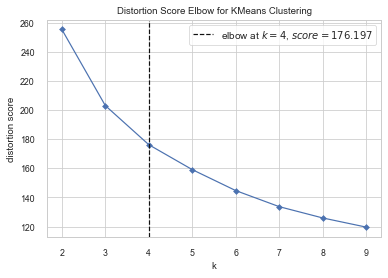

In [71]:
run_elbow(model, fountains_dict[stage_of_interest], stages_fountains_ins, k=10, metric='distortion')



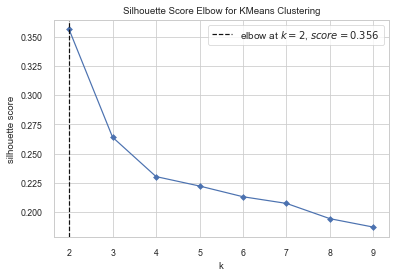

In [72]:
run_elbow(model, fountains_dict[stage_of_interest], stages_fountains_ins, k=10, metric='silhouette')



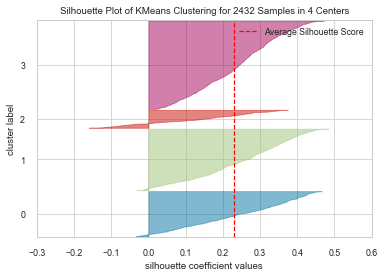

In [73]:
run_silhouette(KMeans(n_clusters=4, random_state=42), fountains_dict[stage_of_interest], stages_fountains_ins, 4)



In [74]:
data_clustering = _clusters_(fountains_dict[stage_of_interest], stages_fountains_ins, method=clustering_method, n_clusters=n_clusters)




In [75]:
slh_norm = silhouette(data_clustering, stages_fountains_ins, 'cluster_' + clustering_method)
slh_norm

0.23048982708541496

In [76]:
data_clustering['cluster_' + clustering_method].value_counts()

3    1009
1     703
0     514
2     206
Name: cluster_kmeans, dtype: int64

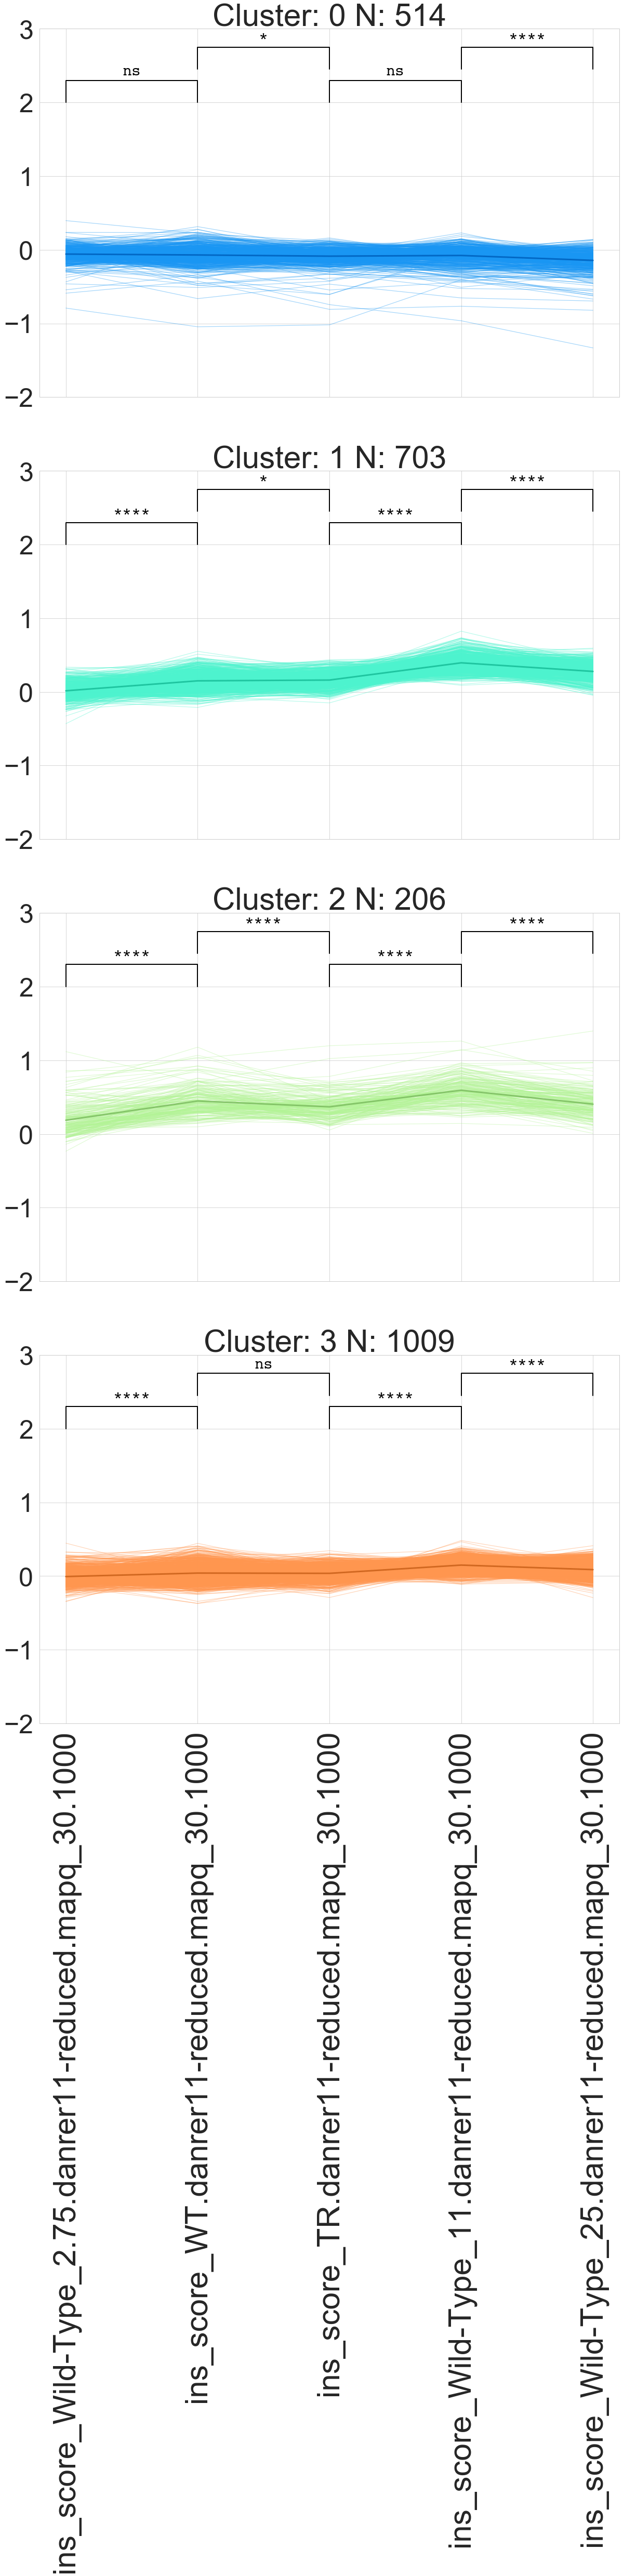

In [77]:
colors = _clusters_dynamics_(data_clustering, stages_fountains_ins, 'cluster_' + clustering_method)

In [78]:
colors1 = [[max(x[0] - 0.1, 0), max(x[1] - 0.3, 0), max(x[2] - 0.3, 0)] for x in colors]

INFO:root:PLOT|PCA| Explained variation per principal component: [0.70108651 0.14801027 0.06932915]


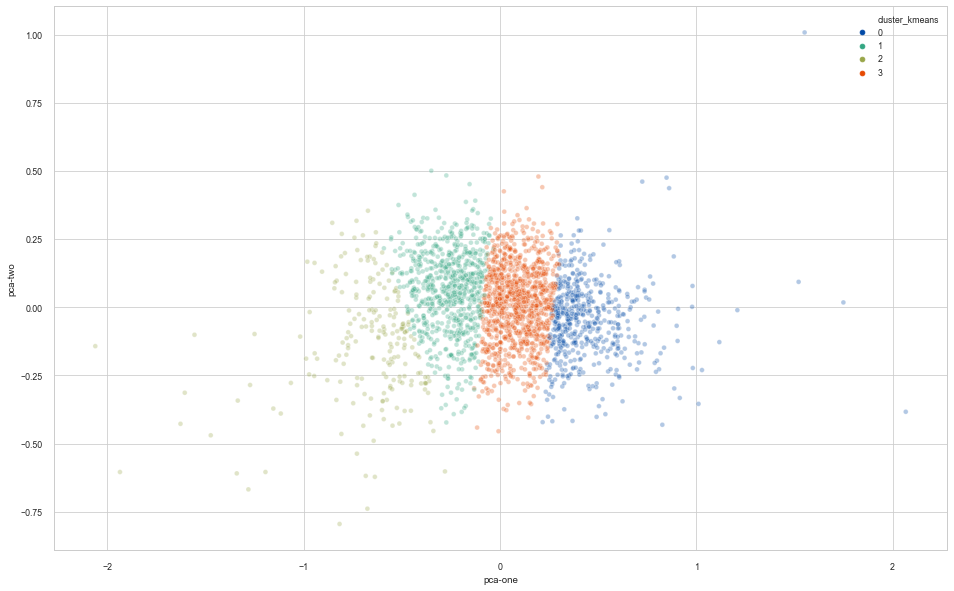

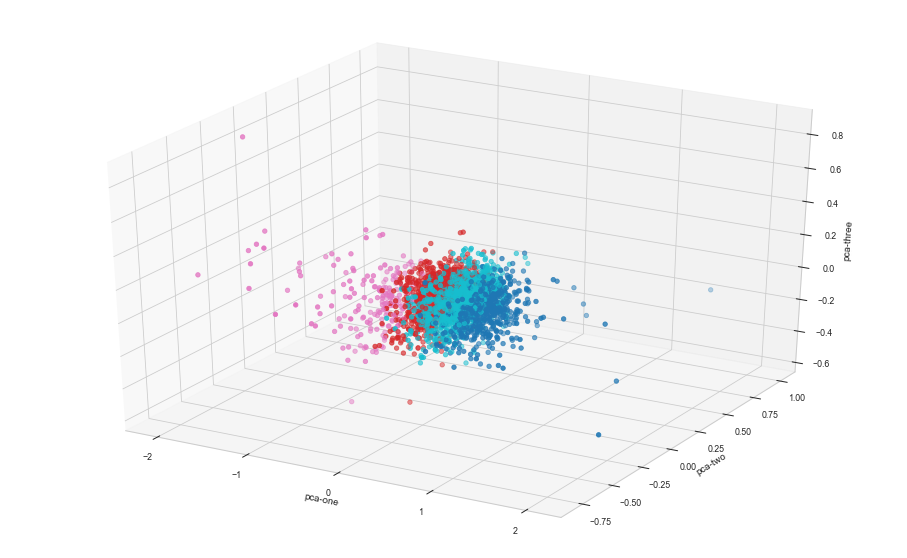

In [79]:
_pca_(data_clustering, stages_fountains_ins, 'cluster_' + clustering_method, colors1, is_pca=True)

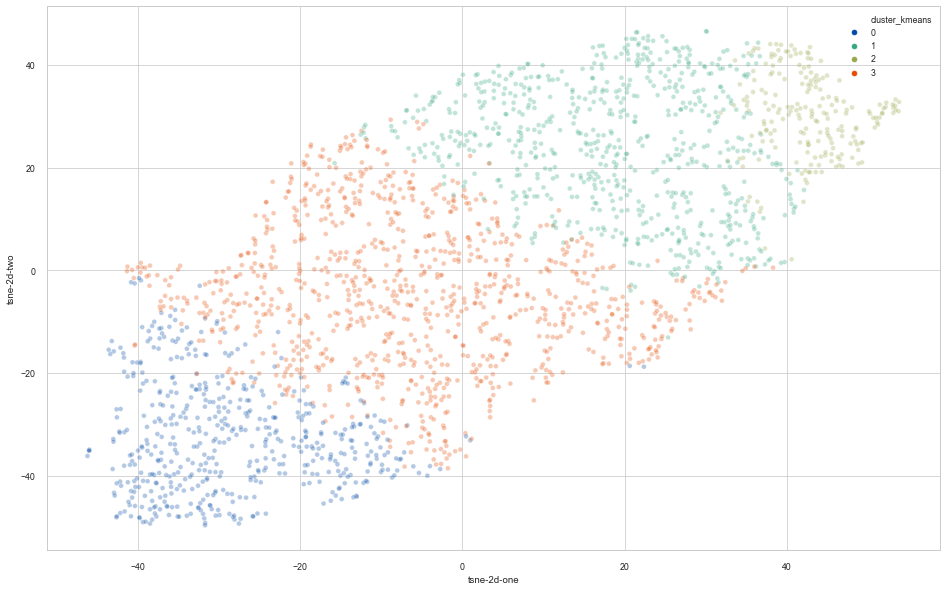

In [80]:
_tsne_(data_clustering, stages_fountains_ins, 'cluster_' + clustering_method, colors1, perplexity=40)

## Boundaries clustering

For fountains found on 25 hrs.

In [83]:
fname = '../arcuda/clustering/figures/boundaries/{}_{}.png'

In [96]:
n_clusters=5

In [84]:
stage_of_interest = 'Wild-Type_25.danrer11-reduced.mapq_30.1000'

In [85]:
stages_boundaries_ins = ['ins_score_{}'.format(x) for x in stages_boundaries]

In [86]:
model = KMeans(random_state=42)

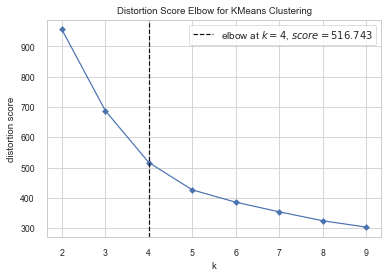

In [87]:
run_elbow(model, boundaries_dict[stage_of_interest], stages_boundaries_ins, k=10, metric='distortion')



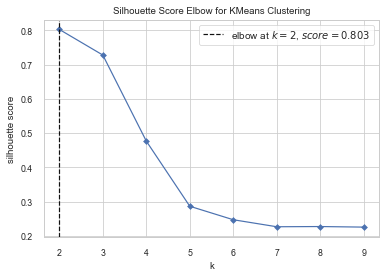

In [88]:
run_elbow(model, boundaries_dict[stage_of_interest], stages_boundaries_ins, k=10, metric='silhouette')



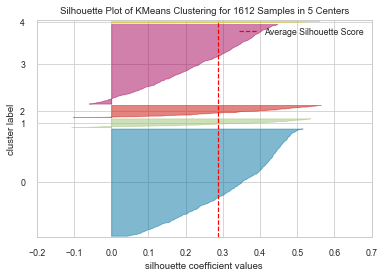

In [99]:
run_silhouette(KMeans(n_clusters=5, random_state=42), boundaries_dict[stage_of_interest], stages_boundaries_ins, 5)



In [100]:
data_clustering = _clusters_(boundaries_dict[stage_of_interest], stages_boundaries_ins, method=clustering_method, n_clusters=n_clusters)




In [101]:
slh_norm = silhouette(data_clustering, stages_boundaries_ins, 'cluster_' + clustering_method)
slh_norm

0.2869672795030046

In [102]:
data_clustering['cluster_' + clustering_method].value_counts()

0    825
3    612
2     93
1     68
4     14
Name: cluster_kmeans, dtype: int64

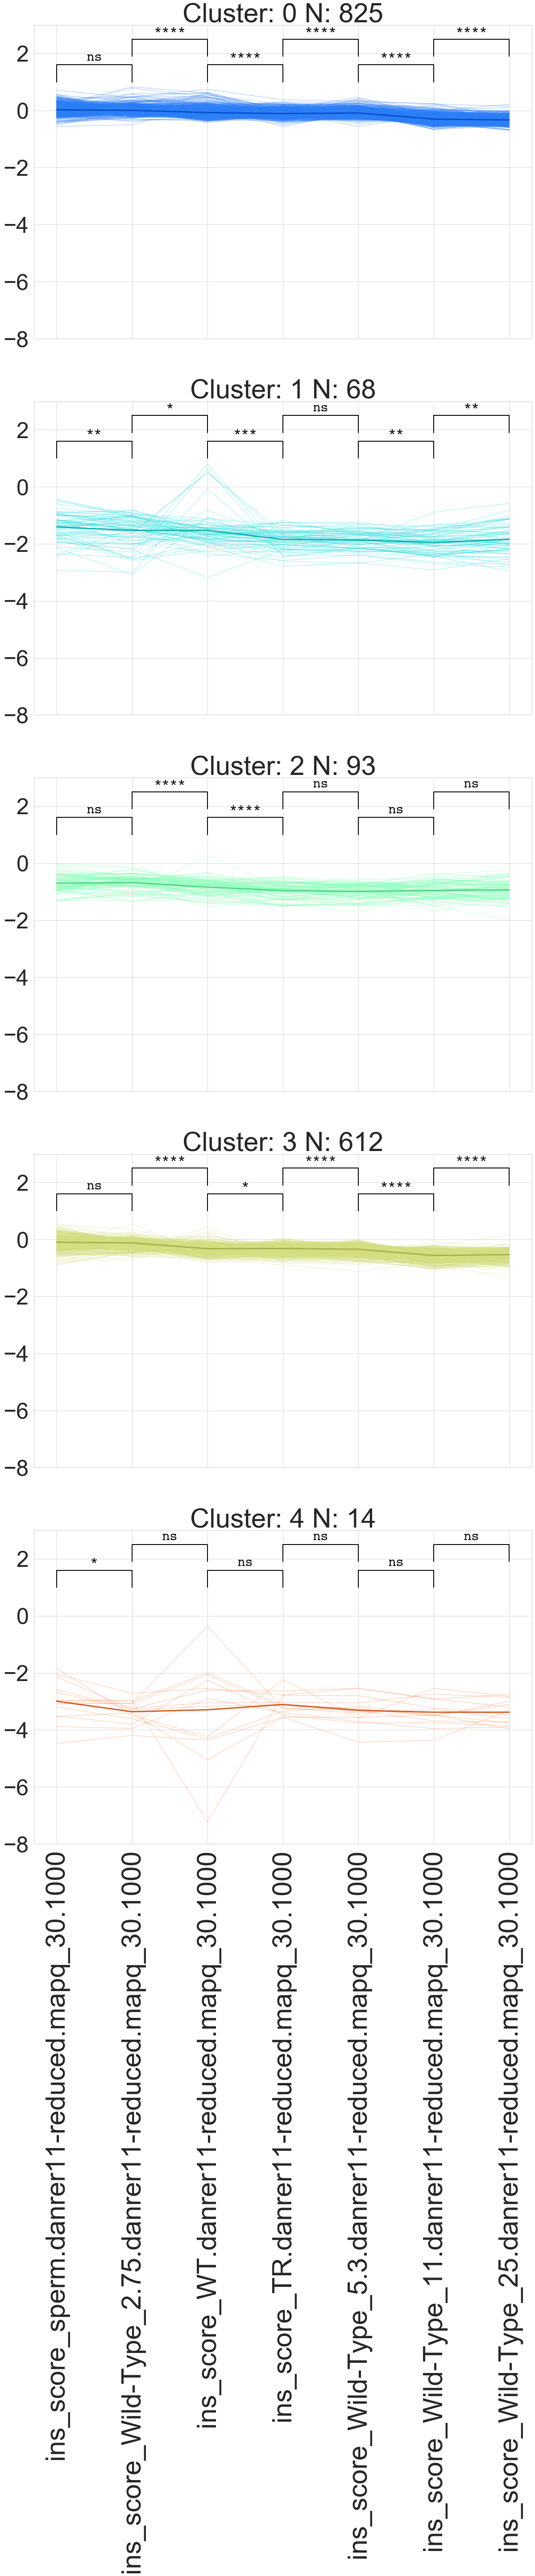

In [103]:
colors = _clusters_dynamics_(data_clustering, stages_boundaries_ins, 'cluster_' + clustering_method)

In [104]:
colors1 = [[max(x[0] - 0.1, 0), max(x[1] - 0.3, 0), max(x[2] - 0.3, 0)] for x in colors]

INFO:root:PLOT|PCA| Explained variation per principal component: [0.89071423 0.04128024 0.02968265]


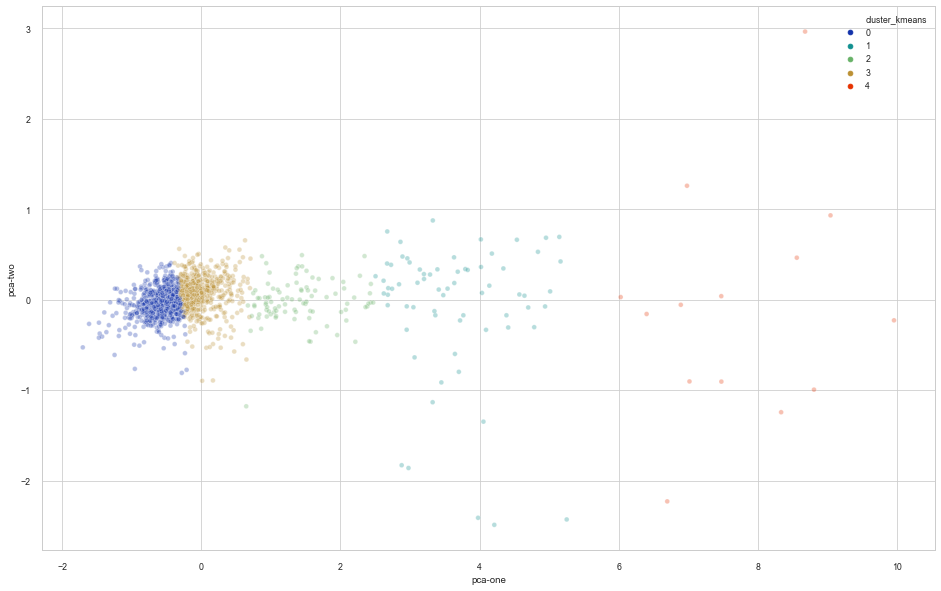

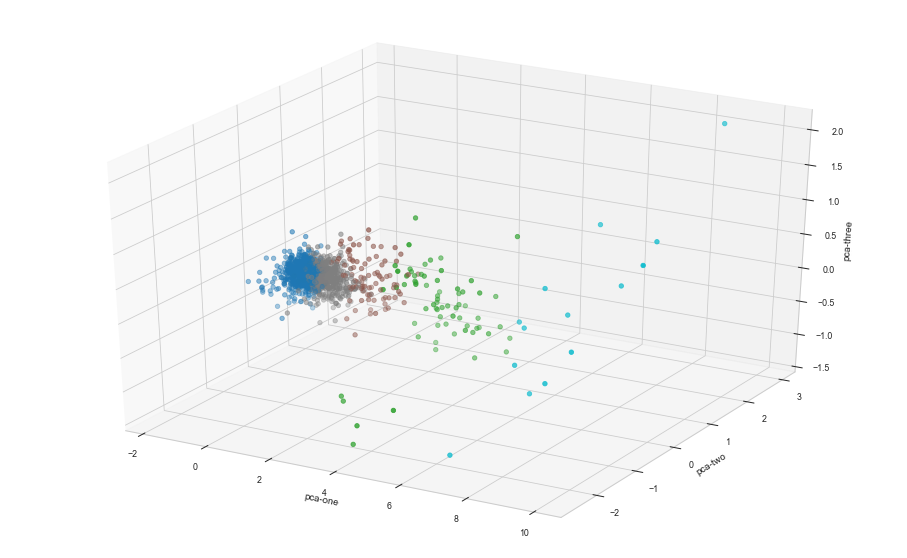

In [105]:
_pca_(data_clustering, stages_boundaries_ins, 'cluster_' + clustering_method, colors1, is_pca=True)

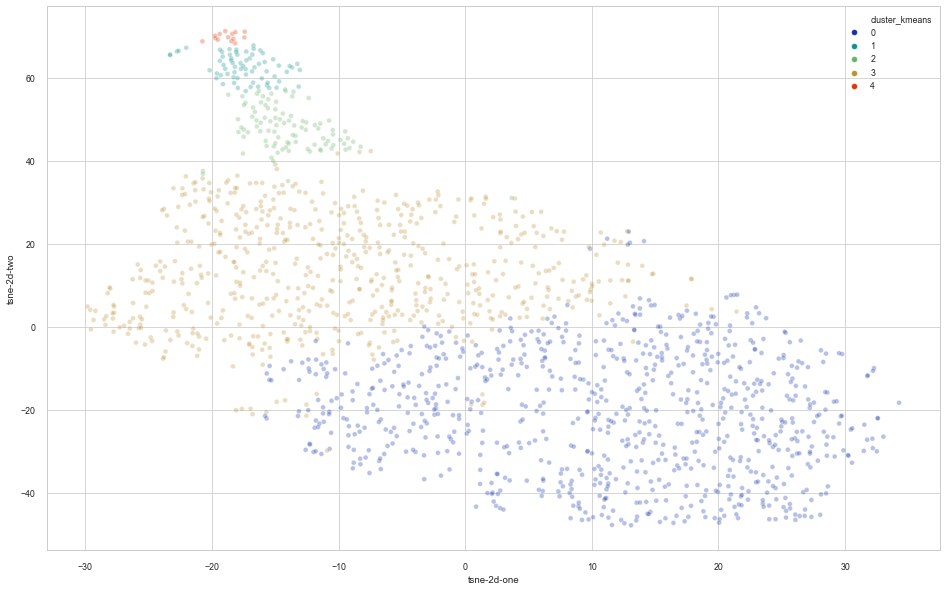

In [106]:
_tsne_(data_clustering, stages_boundaries_ins, 'cluster_' + clustering_method, colors1, perplexity=40)